In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
from astropy.io import ascii

import numpy as np
from scipy.optimize import curve_fit
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
from matplotlib import cm
%matplotlib inline

import glob

In [28]:
# update matplotlib params for bigger font
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'mathtext.fontset': 'stix',
         'font.family': 'STIXGeneral'}

pylab.rcParams.update(params)
plt.style.use("seaborn-whitegrid")

In [4]:
from scipy.ndimage.filters import gaussian_filter

In [5]:
from hetdex_api.shot import *
def load_shot(shot):
        fileh = open_shot_file(shot)
        table = Table(fileh.root.Data.Fibers.read())
        fileh.close()
        return table

In [6]:
def distsq(midra, middec, ras, decs):
    
    """returns the angular distances in arcseconds"""
    
    deccos = np.cos(middec*np.pi/180.)
    return (((ras-midra)*deccos)**2 + (decs-middec)**2)*(3600)**2

In [7]:
def moffat_arcsec(rsq, amp, index, fwhm):#, offset=0):
    
    """returns the moffat function with alpha=index and fwhm in arcseconds."""
    #fwhm = 1.77
    gamma = fwhm/(2 * np.sqrt(2**(1/index)-1))
    return amp * (1 + rsq / gamma**2)**(-index) #+ offset

def moffat_arcsec_3(rsq, amp, fwhm):#, offset=0):
    
    """returns the moffat function with alpha=index and fwhm in arcseconds."""
    #fwhm = 1.77
    index = 3.0
    gamma = fwhm/(2 * np.sqrt(2**(1/index)-1))
    return amp * (1 + rsq / gamma**2)**(-index) #+ offset

def double_moffat(rsq, amp, fcore, index1, index2, fwhm1, fwhm2):
    gamma1 = fwhm1/(2 * np.sqrt(2**(1/3.)-1))
    gamma2 = fwhm2/(2 * np.sqrt(2**(1/3.)-1))
    return amp*(fcore*(1 + rsq / gamma1**2)**(-index1) + (1-fcore)*(1 + rsq / gamma2**2)**(-index2))

def gaussian_arcsec(rsq, amp, fwhm):
    
    sigma_sq = fwhm**2 / 2.35482**2 #(4*2*np.log(2))
    return amp*np.exp(-rsq/(2*sigma_sq)) 

def double_powerlaw_arcsec(rsq, alpha1, alpha2, beta1, beta2):
    cutoff=100
    doublaw = beta1*np.exp(alpha1*rsq) + beta2*np.exp(alpha2*rsq)
    return np.where(doublaw<cutoff, doublaw, cutoff)

def student_t_arcsec(rsq, amp, nu):
    return amp * (1 + rsq/nu)**(-(nu+1)/2.)

In [8]:
def moffat_grid(xgrid, ygrid, amp, fwhm):
    return moffat_arcsec_3(xgrid**2+ygrid**2, amp, fwhm)

def integrated_fibers(rsq, amp, fwhm):
    moffgrid = moffat_grid(xgrid, ygrid, amp, fwhm)
    summed = []
    for r in np.sqrt(rsq/2.0):
        rhere = (xgrid-r)**2+(ygrid-r)**2<1.0
        summed.append(np.nanmean(moffgrid[rhere]))
    return summed

def powerlaw(rsq, amplitude, power):
    return amplitude*rsq**(-power/2.)

In [9]:
xgrid = np.array([np.arange(-1, 10, 0.1) for i in range(110)])
ygrid = xgrid.T

In [10]:
def gaussian(rsq, amplitude, fwhm):
    sigma = fwhm / 2.355
    return amplitude * np.exp(-rsq / (2*sigma**2))

In [11]:
startabs = glob.glob("/data/05865/maja_n/Jupyter/ff2.1_stars/*.tab") #use_stars/*.tab")   #"new_startabs/*.tab") 
laetabs = glob.glob("/data/05865/maja_n/Jupyter/laetabs/*.tab")
laeinfo = ascii.read("/data/05865/maja_n/Jupyter/catalogs/goodlaes.cat")
len(startabs), len(laeinfo), len(laetabs)

(2704, 435, 431)

In [12]:
psf_shape = ascii.read("/data/05865/maja_n/Jupyter/PSF_runbiw.dat")
psf_shape

r/fwhm,runbiw_local,runbiw_local_err,runbiw_fullframe,runbiw_fullframe_err,runbiw_fullframe_2.1,runbiw_fullframe_err_2.1
float64,float64,float64,float64,float64,float64,float64
0.0,0.9546577325763922,0.08871068875754351,0.9522000637793022,0.08365238200985986,1.0020595231913374,0.11954014956693076
0.02,0.9935719291691487,0.054342475666450965,0.9958533054748855,0.04752709131027373,0.9724444975773346,0.05514646005378039
0.04,0.9642282997257167,0.03172578407026107,0.9730794205996959,0.03508736337094651,0.9674307446796622,0.03798128500614461
0.06,0.9530081299092027,0.04140269972148294,0.9670778670917046,0.03506638740737703,0.9683474837674027,0.034216084907159834
0.08,0.9468723461894201,0.02963780860823539,0.9713209546420555,0.0371961213522865,0.9597280877798539,0.032904057312316076
0.1,0.9307615704227891,0.026506252181846657,0.94203550841914,0.03076711755252424,0.9416584848998338,0.03219937539315261
0.12,0.9067119150110531,0.027730794458075525,0.9085479551572906,0.032140526572346055,0.9228061625723482,0.029992872062879625
0.14,0.9058177625881902,0.023413677393933876,0.903096966037512,0.027140415030795135,0.8884486934426848,0.0291017720609242
0.16,0.8760804440433748,0.02110585792691555,0.882424571270514,0.028784764470570903,0.8873315116103201,0.028390869679333196


In [13]:
def fit_psf(r, amplitude, fwhm):
    ys = np.interp(r/fwhm, psf_shape["r/fwhm"], psf_shape["runbiw_filt"])
    return amplitude * ys

In [16]:
fitres = ascii.read("/data/05865/maja_n/Jupyter/fit_results.tab")
amps_in, fwhms_in, inds_in = fitres["amp"], fitres["fwhm"], fitres["index"]

In [17]:
MOCK = False
if MOCK:
    table=load_shot("20190104v017")
    def_wave = np.arange(3470, 5542, 2.)
    wlhere = np.where((def_wave>=4450)&(def_wave<=4550))[0]

In [18]:
GAUSSIAN = False
POWERLAWS = False
STUDENTT = False
INTEGRATE = False
POWERLAW = False
PSFSHAPE = False

STARS = True
if STARS:
    tabs = startabs
    fluxkey = "flux"
    errkey = "std"
else:
    tabs = laetabs
    fluxkey = "full_skysub"
    errkey = "std/sqrt(N-q)"

results = []
pcovs = []
shotresults = []
shotidx = -1
oldshot = "111111"
testdists = np.arange(0., 13., 0.2)
starids = []
normalized = []
distances = []
for sf in tabs[:]: # laetabs[:]:#
    try:
        if STARS:
            shot = sf.split("_")[2]
            starid = sf.split("_")[3][:-4]
        #print(shot)
        #if shot!=oldshot:
        #    shotidx += 1
        else:
            detectid = int(sf.split("/")[-1][:-4])
            
            
        ############################ Check if this is actually ok data #############################

        if not MOCK:
            a = ascii.read(sf)
            a = a[np.isfinite(a[fluxkey])&(a[fluxkey]!=0.0)] #a[np.isfinite(a["flux"])&(a["flux"]!=0.0)]
            if len(a)<1:
                continue
            if STARS:
                rsq = distsq(a[0]["star_ra"], a[0]["star_dec"], a["ra"].data, a["dec"].data) # in arcseconds
            else:
                midra, middec = laeinfo["ra"][laeinfo["detectid"]==detectid], laeinfo["dec"][laeinfo["detectid"]==detectid]
                rsq = distsq(midra, middec, a["ra"], a["dec"])
            a = a[np.sqrt(rsq) < 13.]
            rsq = rsq[np.sqrt(rsq) < 13.]
            if len(rsq)<1:
                continue
            elif np.nanmin(rsq)>1.5**2:
                continue
            
        ########################## Create mock stars with the same distances #######################
        
        if MOCK:
            i0 = random.randint(0, len(table)-1)
            i1, i2, i3 = random.randint(0, len(amps_in)-1), random.randint(0, len(amps_in)-1), random.randint(0, len(amps_in)-1)   
            rsq = distsq(table[i0]["ra"], table[i0]["dec"], table["ra"].data, table["dec"].data) # in arcseconds
            table_0 = table[np.sqrt(rsq) < 13.]
            rsq = rsq[np.sqrt(rsq) < 13.]
            gain = table_0["calfib_counts"] / table_0["calfib"]
            
            amp, fwhm, idx = amps_in[i1], fwhms_in[i2], inds_in[i3]
            
            ### add a gaussian this time, and fit a moffat function # 
            function_to_add = gaussian(rsq, amp, fwhm) #moffat_arcsec(rsq, amp, idx, fwhm)
            function_to_add_counts = np.round((gain[:,wlhere].T * moffat_arcsec(rsq, amp, idx, fwhm)).T)
            function_to_add_counts[~np.isfinite(function_to_add_counts)] = 0.0
            poisson_func_to_add = np.random.poisson(lam=function_to_add_counts)
            retranslated_to_add = poisson_func_to_add / gain[:,wlhere]
            retranslated_to_add[~np.isfinite(retranslated_to_add)] = 0.0

            moff_all = table_0["calfib"][:,wlhere]  + retranslated_to_add
            #moff_all = (table_0["calfib"][:,wlhere].T + moffat_arcsec(rsq, amp, idx, fwhm)).T
            moff = np.nanmean(moff_all, axis=1)   #np.random.normal(loc=0, scale=20*a["std"])
            stds = np.nanstd(moff_all, axis=1)
            p0 = [np.nanmax(moff), 3, 1.7]
            popt, pcov = curve_fit(moffat_arcsec, rsq, moff, sigma=stds, p0=p0)
            
        ######################### Fit a function to the data or to the mocks ############################
        
        elif INTEGRATE:
            p0 = [np.nanmax(a[fluxkey].data), 1.7]
            popt, pcov = curve_fit(integrated_fibers, rsq, a[fluxkey], sigma=a[errkey], p0=p0)
            
        elif GAUSSIAN:
            p0 = [np.nanmax(a["flux"].data), 1.7]
            popt, pcov = curve_fit(gaussian_arcsec, rsq, a["flux"], sigma=a["std"], p0=p0)
        elif POWERLAWS:
            maxflux = np.nanmax(a["flux"].data)
            p0 = [-3, -0.5, maxflux, maxflux/10.]    # alpha1, alpha2, beta1, beta2
            popt, pcov = curve_fit(double_powerlaw_arcsec, rsq, a["flux"], sigma=a["std"], p0=p0)
        elif STUDENTT:
            maxflux = np.nanmax(a["flux"].data)
            p0 = [maxflux, 1.]
            popt, pcov = curve_fit(student_t_arcsec, rsq, a["flux"], sigma=a["std"], p0=p0)
        elif POWERLAW:
            p0 = [np.nanmax(a[fluxkey]), 2.4]
            popt, pcov = curve_fit(powerlaw, rsq, a[fluxkey], sigma=a[errkey], p0=p0)
            popt2, pcov2 = curve_fit(moffat_arcsec_3, rsq, a[fluxkey], sigma=a[errkey], p0=[p0[0], 1.7])
            
        elif PSFSHAPE:
            p0 = [np.nanmax(a[fluxkey]), 1.7]
            popt, pcov = curve_fit(fit_psf, np.sqrt(rsq), a["flux"], sigma=a["std"], p0=p0)
            
        else:
            p0 = [np.nanmax(a[fluxkey].data), 1.7] #3, 1.7]#, 0.1]
            popt, pcov = curve_fit(moffat_arcsec_3, rsq, a[fluxkey], sigma=a[errkey], p0=p0)
            
            
        ########################### Maybe plot data and fit ###########################################
        
        if False:
            plt.figure()
            #plt.errorbar(np.sqrt(rsq), moff, stds, fmt=".")
            plt.errorbar(np.sqrt(rsq), a[fluxkey], yerr=a[errkey], fmt=".")
            #plt.plot(testdists, double_powerlaw_arcsec(testdists, *popt))
            #plt.plot(testdists, moffat_arcsec_3(testdists**2, popt2[0], 1.7), label="PSF")#*popt))
            plt.plot(testdists, fit_psf(testdists, *popt), label="PSF shape")
            #plt.plot(testdists, student_t_arcsec(testdists**2, *popt))
            plt.title(popt)
            #plt.ylim(-0.5, np.nanmax(a[fluxkey])+0.3)
            plt.legend()
            #plt.yscale("log")
            #plt.xscale("log")
        results.append(popt)
        pcovs.append(pcov)
        if MOCK:
            normalized.append(moff/popt[0])
        else:
            normalized.append(a[fluxkey].data/popt[0])
        distances.append(rsq)
        shotresults.append(shotidx)#int(shot))#idx)
        if STARS:
            starids.append(starid)
        else:
            starids.append(detectid)
    except RuntimeError as e:
        print(e)
        pass

Optimal parameters not found: Number of calls to function has reached maxfev = 600.
Optimal parameters not found: Number of calls to function has reached maxfev = 600.


In [19]:
normalized = np.array(normalized)
distances = np.array(distances)
amps, fwhms = np.array([x[0] for x in results]), np.array([x[1] for x in results])
shots = shotresults
if GAUSSIAN:
    amps, fwhms = np.array([x[0] for x in results]), np.array([x[1] for x in results])
    amperr, fwhmerr = np.array([np.sqrt(x[0][0]) for x in pcovs]), np.array([np.sqrt(x[1][1]) for x in pcovs])

elif False: # since I force beta=3
    amps, indices, fwhms = np.array([x[0] for x in results]), np.array([x[1] for x in results]), np.array([x[2] for x in results])#, np.array([x[3] for x in results])
    amperr, indexerr, fwhmerr = np.array([np.sqrt(x[0][0]) for x in pcovs]), np.array([np.sqrt(x[1][1]) for x in pcovs]), np.array([np.sqrt(x[2][2]) for x in pcovs])#, np.array([np.sqrt(x[3][3]) for x in pcovs])
else:
    amps, fwhms = np.array([x[0] for x in results]), np.array([x[1] for x in results])
    amperr, fwhmerr = np.array([np.sqrt(x[0][0]) for x in pcovs]), np.array([np.sqrt(x[1][1]) for x in pcovs])

In [20]:
withinbouds = (fwhms<4)&(fwhms>1.2)&(amps>1)&(amps<300)&(fwhms!=1.7)#&(indices!=3) #(indices>0)&# np.ones(len(fwhms), dtype=bool)# (fwhms<6)&(fwhms>0)&(amps>0)&(amps<500)
len(fwhms[withinbouds]), len(fwhms)

(2558, 2637)

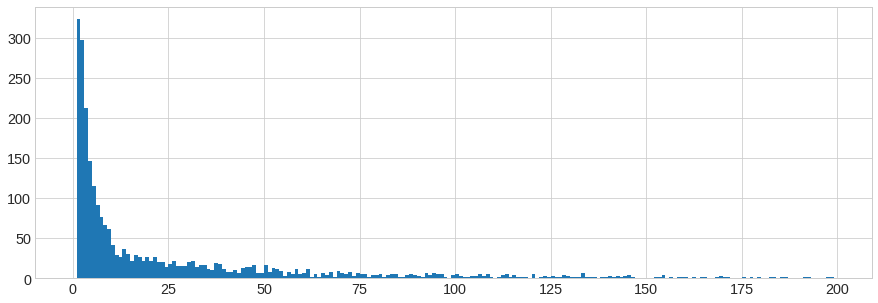

In [21]:
plt.hist(amps[withinbouds], bins=np.arange(0, 200, 1));

In [22]:
roverfwhm = []
norm_values = []
for x, y, fwhm in zip(distances[withinbouds], normalized[withinbouds], fwhms[withinbouds]):
    roverfwhm.append(np.sqrt(x)/fwhm)
    norm_values.append(y)

In [23]:
roverfwhm = np.concatenate(roverfwhm)
norm_values = np.concatenate(norm_values)
order = np.argsort(roverfwhm)
roverfwhm = roverfwhm[order]
norm_values = norm_values[order]

In [24]:
from astropy.stats import biweight_location, biweight_scale

In [25]:
medfilt = []
lower = []
upper = []
Ns = []
errs = []
xbins = np.arange(0, 5, 0.02)
for x, y in zip(xbins[:-1], xbins[1:]):
    here = (roverfwhm>=x)&(roverfwhm<y)
    loc = biweight_location(norm_values[here])
    scale = biweight_scale(norm_values[here])
    N = len(here[here])
    Ns.append(N)
    medfilt.append(loc)
    err = np.sqrt(scale / (N-1))
    lower.append(loc-err)
    upper.append(loc+err)
    errs.append(err)

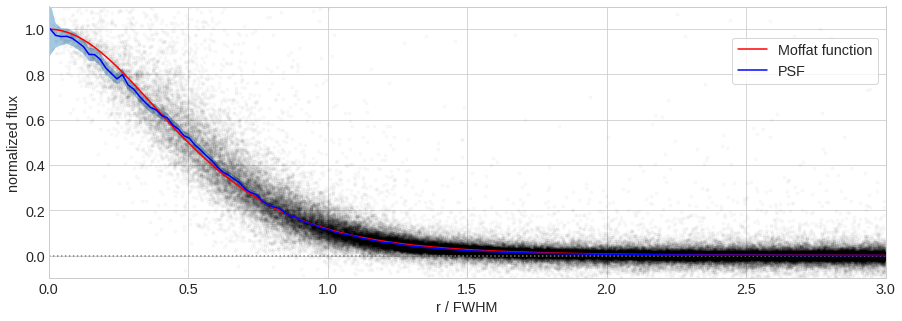

In [30]:
plt.plot(roverfwhm, norm_values, ".k", alpha=0.02)
#plt.plot(roverfwhm, median_filter(norm_values, size=200))
plt.axhline(0, color="gray", linestyle=":")
plt.plot(xbins[:-1]+0.005, moffat_arcsec_3((xbins[:-1]+0.005)**2, 1, 1), color="r", label="Moffat function")
#plt.plot(xbins[1:-1]+0.005, gaussian_filter(medfilt[1:], sigma=1.2), color="blue", label="running biweight filtered")
plt.plot(xbins[:-1]+0.005, medfilt, color="blue", label="PSF")#running biweight")
plt.fill_between(xbins[:-1]+0.005, lower, upper, alpha=0.4)
#plt.plot(a["r/fwhm"], a["runbiw"])
plt.ylim(-0.1, 1.1)
plt.xlim(0, 3)
plt.ylabel("normalized flux")
plt.xlabel("r / FWHM")
#plt.title("normalized stars and running biweight")
plt.legend(bbox_to_anchor=(1, 0.8), frameon=True)
#plt.savefig("plots/running_biweight_normed_psf_ff2.1_thesis.png", bbox_inches="tight")

KeyError: 'runbiw_iter'

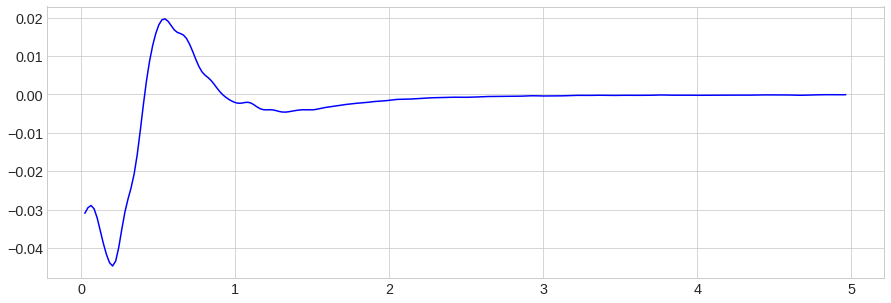

In [28]:
#plt.plot(xbins[:-1]+0.005, medfilt-moffat_arcsec_3((xbins[:-1]+0.005)**2, 1, 1), color="r", label="running biweight - moffat")
plt.plot(xbins[1:-1]+0.005, gaussian_filter(medfilt[1:], sigma=2)-moffat_arcsec_3((xbins[1:-1]+0.005)**2, 1, 1), color="blue", label="filtered running biweight - moffat (full-frame)")
#plt.plot(xbins[:-1]+0.005, psf_shape["runbiw_iter"]-moffat_arcsec_3((xbins[:-1]+0.005)**2, 1, 1), color="tab:green", label="running biweight - moffat (local)")
plt.plot(xbins[1:-1]+0.005, gaussian_filter(psf_shape["runbiw_iter"][1:], sigma=2)-moffat_arcsec_3((xbins[1:-1]+0.005)**2, 1, 1), color="red", label="filtered running biweight - moffat (local)")
#plt.plot(xbins[:-1]+0.005, medfilt, color="blue", label="running biweight")
#plt.fill_between(xbins[:-1]+0.005, lower, upper, alpha=0.4)
plt.xlim(0,5)
plt.legend(frameon=True)
plt.xlabel("r/FWHM")
plt.ylabel("normalized flux")
#plt.savefig("plots/runbiw_minus_moffat_local_ff.png", bbox_inches="tight")

In [14]:
new_psf = ascii.read("PSF_runbiw.dat")
#new_psf["runbiw_fullframe_2.1"] = medfilt
#new_psf["runbiw_fullframe_err_2.1"] = errs

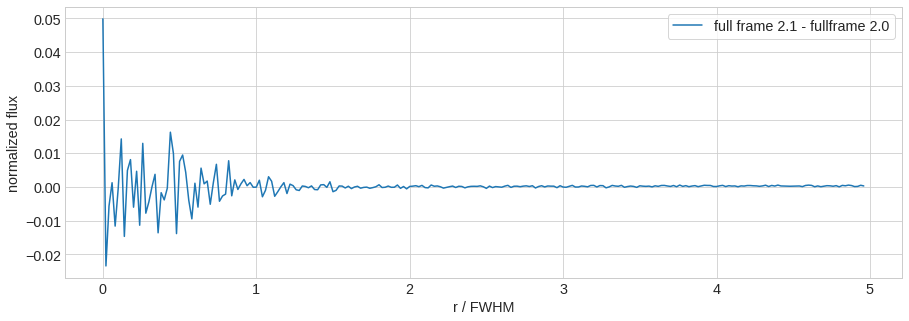

In [15]:
plt.figure()
#plt.plot(new_psf["r/fwhm"], new_psf["runbiw_fullframe"] - new_psf["runbiw_local"], label="full frame - local")
plt.plot(new_psf["r/fwhm"], new_psf["runbiw_fullframe_2.1"] - new_psf["runbiw_fullframe"], label="full frame 2.1 - fullframe 2.0")
#plt.plot(new_psf["r/fwhm"], gaussian_filter(new_psf["runbiw_fullframe_2.1"], sigma=2) - gaussian_filter(new_psf["runbiw_fullframe"], sigma=2), label="full frame 2.1 - fullframe 2.0")
#plt.plot(new_psf["r/fwhm"], gaussian_filter(new_psf["runbiw_fullframe"], sigma=2)-gaussian_filter(new_psf["runbiw_local"], sigma=2), label="smoothed full frame - smoothed local")
plt.ylabel("normalized flux")
plt.xlabel("r / FWHM")
plt.legend(frameon=True)
#plt.savefig("plots/PSF_fullframe_2.1_minus_2.png")

(0.0, 1.0)

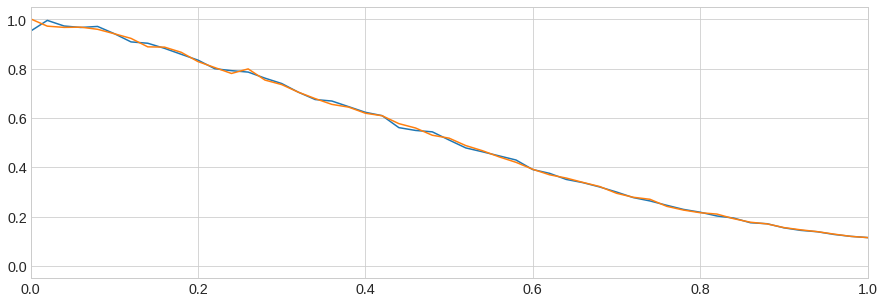

In [16]:
plt.figure()
plt.plot(new_psf["r/fwhm"], new_psf["runbiw_fullframe"], label="full frame HDR2")
plt.plot(new_psf["r/fwhm"], new_psf["runbiw_fullframe_2.1"], label="full frame HDR2.1")
plt.xlim(0,1)


In [32]:
#ascii.write(new_psf, "PSF_runbiw.dat")

In [80]:
!p

r/fwhm,runbiw_local,runbiw_local_err,runbiw_fullframe,runbiw_fullframe_err
float64,float64,float64,float64,float64
0.0,0.9546577325763922,0.08871068875754351,0.9522000637793022,0.08365238200985986
0.02,0.9935719291691487,0.054342475666450965,0.9958533054748855,0.04752709131027373
0.04,0.9642282997257167,0.03172578407026107,0.9730794205996959,0.03508736337094651
0.06,0.9530081299092027,0.04140269972148294,0.9670778670917046,0.03506638740737703
0.08,0.9468723461894201,0.02963780860823539,0.9713209546420555,0.0371961213522865
0.1,0.9307615704227891,0.026506252181846657,0.94203550841914,0.03076711755252424
0.12,0.9067119150110531,0.027730794458075525,0.9085479551572906,0.032140526572346055
0.14,0.9058177625881902,0.023413677393933876,0.903096966037512,0.027140415030795135
0.16,0.8760804440433748,0.02110585792691555,0.882424571270514,0.028784764470570903


In [47]:
#new_psf = Table()
#new_psf["r/fwhm"] = xbins[:-1]
#new_psf["runbiw_local"] = medfilt
#new_psf["runbiw_local_err"] = errs

In [65]:
stars_roverfwhm = roverfwhm.copy()
stars_norm = norm_values.copy()

Text(0.5, 0, 'r / FWHM')

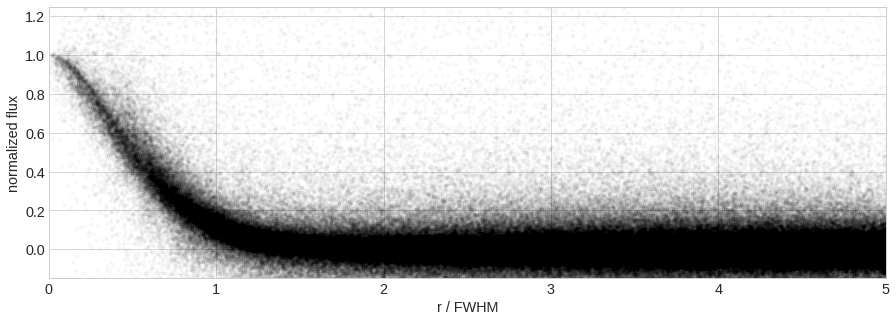

In [17]:
plt.figure()
colors_ar = cm.viridis(np.logspace(-5, 0, len(amps[withinbouds])))
for x, y, fwhm in zip(distances[withinbouds], normalized[withinbouds], fwhms[withinbouds]):
    plt.plot(np.sqrt(x)/fwhm, y, ".k", alpha=.02)
plt.ylim(-0.15, 1.25)
plt.xlim(0, 5)
plt.ylabel("normalized flux")
plt.xlabel("r / FWHM")
#plt.savefig("plots/normalized_stars_psf_roverfwhm_gaussian.png", bbox_inches="tight")

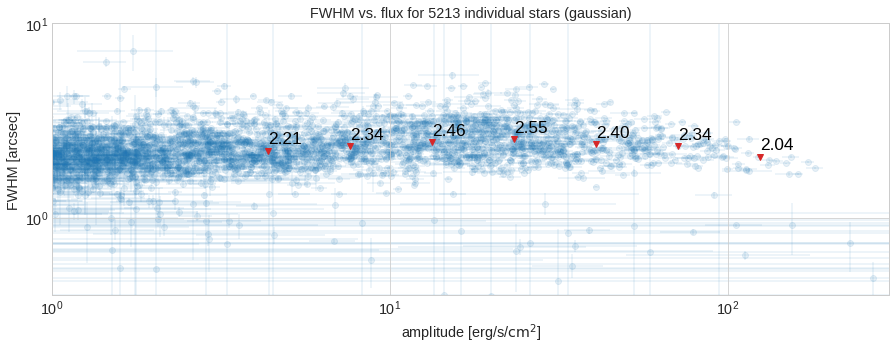

In [23]:
plt.errorbar(amps[withinbouds], fwhms[withinbouds], xerr=amperr[withinbouds], yerr=fwhmerr[withinbouds], alpha=0.1, fmt="o", zorder=0)#, c=shots, cmap="prism")

for lower, upper in zip(np.logspace(0.5,2.2,8)[:-1], np.logspace(0.5,2.2,8)[1:]): #np.arange(0,300,20), np.arange(10,320,20)):
    ampshere = (amps>=lower)&(amps<upper)&withinbouds
    plt.plot(lower+(upper-lower)/2, np.nanmedian(fwhms[ampshere]),marker="v", c="tab:red", alpha=1.0, zorder=1)
    plt.text(lower+(upper-lower)/2, np.nanmedian(fwhms[ampshere])+0.2, "{:.2f}".format(np.nanmedian(fwhms[ampshere])) , color="k", zorder=2, fontsize="xx-large")# str(len(ampshere[ampshere]))
#for lower, upper in zip(np.arange(0,300,20), np.arange(10,320,20)):
#    ampshere = (amps>=lower)&(amps<upper)&withinbouds
#    plt.plot(lower+5, np.nanmedian(fwhms[ampshere]),marker="v", c="tab:red", alpha=1.0, zorder=1)
plt.xlim(1,300)
plt.ylim(0.4, 10)
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"amplitude [erg/s/$\mathrm{cm}^2$]")
plt.ylabel("FWHM [arcsec]")
plt.title("FWHM vs. flux for {} individual stars (gaussian)".format(len(fwhms[withinbouds])))
#plt.savefig("plots/FWHM_flux_gaussian_fit.png", bbox_inches="tight")

In [19]:
import matplotlib.cm as cm

import matplotlib.colors as colors

In [55]:
def gammasq(fwhm, index):
    return fwhm**2/(4 * (2**(1/index)-1))

In [23]:
gammas = gammasq(fwhms[withinbouds], indices[withinbouds])
np.nanmedian(gammas), np.exp(np.nanmedian(np.log(gammas)))

NameError: name 'indices' is not defined

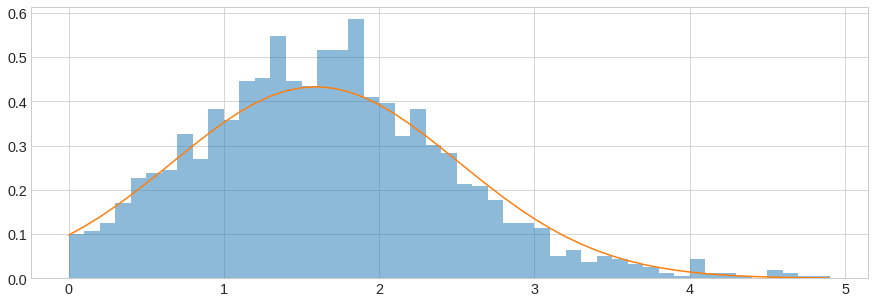

In [60]:
plt.hist(np.log(gammas), bins=np.arange(0, 5, 0.1), density=True, alpha=0.5)
plt.plot(np.arange(0, 5, 0.1), stats.norm.pdf(np.arange(0, 5, 0.1), loc=biweight_location(np.log(gammas)), scale=biweight_scale(np.log(gammas))));

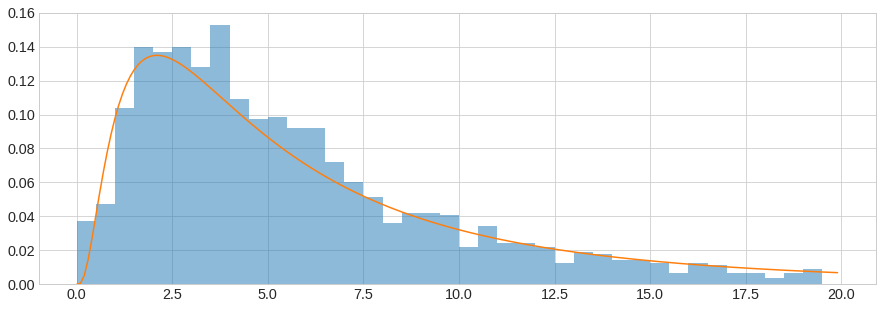

In [64]:
plt.hist(gammas, bins=np.arange(0, 20, 0.5), density=True, alpha=0.5)
plt.plot(np.arange(0, 20, 0.1), stats.lognorm.pdf(np.arange(0, 20, 0.1), scale=np.exp(biweight_location(np.log(gammas))), s=biweight_scale(np.log(gammas))));
print("""scale: {}
s: {}""".format(np.exp(biweight_location(np.log(gammas))), ))

In [24]:
from astropy.stats import biweight_scale, biweight_location

Text(0.5, 1.0, 'Moffat index vs. flux for 6223 individual stars (mocks)')

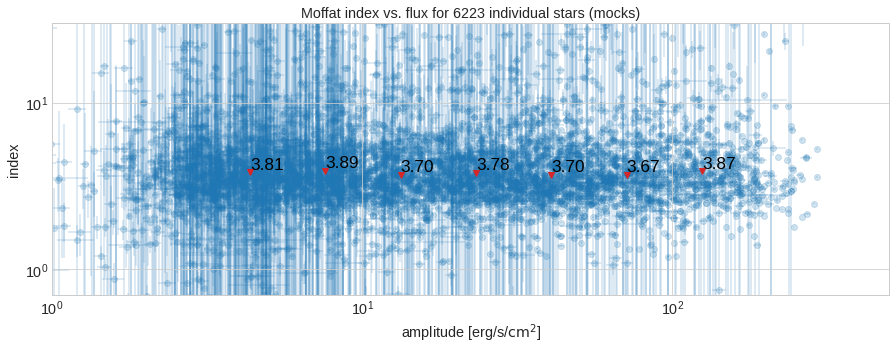

In [22]:
plt.errorbar(amps[withinbouds], indices[withinbouds], xerr=amperr[withinbouds], yerr=indexerr[withinbouds], alpha=0.2, fmt="o", zorder=0)#, c=shots, cmap="prism")
for lower, upper in zip(np.logspace(0.5,2.2,8)[:-1], np.logspace(0.5,2.2,8)[1:]): #np.arange(0,300,20), np.arange(10,320,20)):
    ampshere = (amps>=lower)&(amps<upper)&withinbouds
    plt.plot(lower+(upper-lower)/2, np.nanmedian(indices[ampshere]),marker="v", c="tab:red", alpha=1.0, zorder=1)
    plt.text(lower+(upper-lower)/2, np.nanmedian(indices[ampshere])+0.2, "{:.2f}".format(np.nanmedian(indices[ampshere])) , color="k", zorder=2, fontsize="xx-large")
    #plt.axvline(lower, linestyle="--", color="red")
    #plt.axvline(upper, linestyle="--", color="red")
plt.xlim(1,500)
plt.ylim(0.7, 30)
#plt.xlim(1, 500)
#plt.ylim(0.7, 1e3)
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"amplitude [erg/s/$\mathrm{cm}^2$]")
plt.ylabel("index")
plt.title("Moffat index vs. flux for {} individual stars (mocks)".format(len(fwhms[withinbouds])))
#plt.savefig("plots/idx_flux_mocks_poisson.png", bbox_inches="tight")

Text(0.5, 1.0, 'FWHM vs. flux for 6223 individual stars (mocks)')

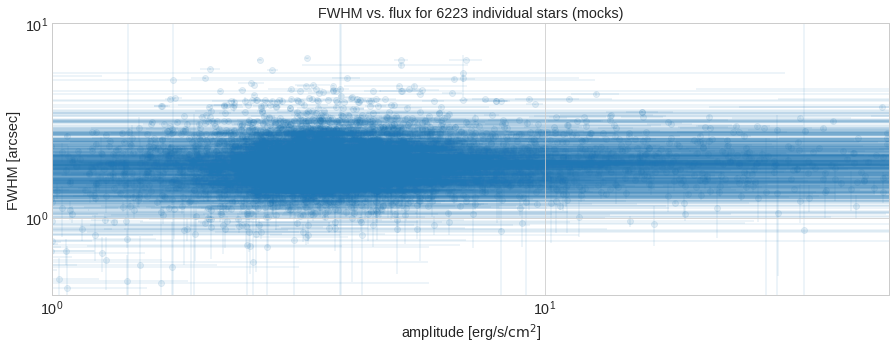

In [21]:
plt.errorbar(indices[withinbouds], fwhms[withinbouds], xerr=indexerr[withinbouds], yerr=fwhmerr[withinbouds], alpha=0.1, fmt="o", zorder=0)#, c=shots, cmap="prism")

#for lower, upper in zip(np.logspace(0.5,2.2,8)[:-1], np.logspace(0.5,2.2,8)[1:]): #np.arange(0,300,20), np.arange(10,320,20)):
#    ampshere = (amps>=lower)&(amps<upper)&withinbouds
#    plt.plot(lower+(upper-lower)/2, np.nanmedian(fwhms[ampshere]),marker="v", c="tab:red", alpha=1.0, zorder=1)
#    plt.text(lower+(upper-lower)/2, np.nanmedian(fwhms[ampshere]), str(len(ampshere[ampshere])), color="black", zorder=2, fontsize="xx-large")
#for lower, upper in zip(np.arange(0,300,20), np.arange(10,320,20)):
#    ampshere = (amps>=lower)&(amps<upper)&withinbouds
#    plt.plot(lower+5, np.nanmedian(fwhms[ampshere]),marker="v", c="tab:red", alpha=1.0, zorder=1)
plt.xlim(1,50)
plt.ylim(0.4, 10)
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"amplitude [erg/s/$\mathrm{cm}^2$]")
plt.ylabel("FWHM [arcsec]")
plt.title("FWHM vs. flux for {} individual stars (mocks)".format(len(fwhms[withinbouds])))
#plt.savefig("plots/FWHM_idx_stars.png", bbox_inches="tight")

(0.0, 5.0)

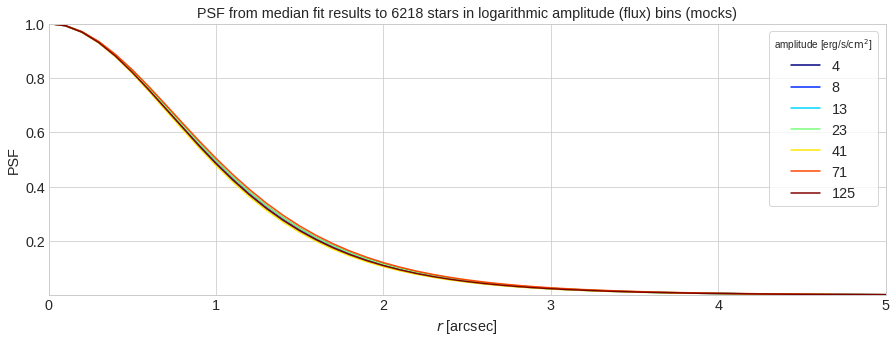

In [69]:
testdists = np.arange(0, 13, 0.1)
cm_subsection = np.linspace(0,1,7)
colors = [ cm.jet(x) for x in cm_subsection ]
i=0
fwhms_1, idx_1 = [], []
for lower, upper in zip(np.logspace(0.5,2.2,8)[:-1], np.logspace(0.5,2.2,8)[1:]): #np.arange(0,300,20), np.arange(10,320,20)):
    ampshere = (amps>=lower)&(amps<upper)&withinbouds
    
    amp0, fwhm0, idx0 = lower+(upper-lower)/2., np.nanmedian(fwhms[ampshere]), 3.0#np.nanmedian(indices[ampshere])#, np.nanmedian(offsets[ampshere])
    area0 = amp0#/(idx0-1)*(np.pi*(fwhm0/(2 * np.sqrt(2**(1/3.)-1)))**2)
    plt.plot(testdists, moffat_arcsec(testdists**2, amp0, idx0, fwhm0)/area0, label="{:.0f}".format(amp0), color=colors[i])
    i+=1
    fwhms_1.append(fwhm0)
    idx_1.append(idx0)
plt.legend(frameon=True, title=r"amplitude [erg/s/$\mathrm{cm}^2$]")
plt.title("PSF from median fit results to {} stars in logarithmic amplitude (flux) bins (mocks)".format(len(fwhms[withinbouds])))
plt.ylabel("PSF")
plt.xlabel(r"$r$ [arcsec]")
plt.ylim(1e-6, 1)
plt.xlim(0, 5)
#plt.yscale("log")
#plt.xscale("log")
#plt.savefig("plots/mid_psf_shape_mocks_data.png", bbox_inches="tight")

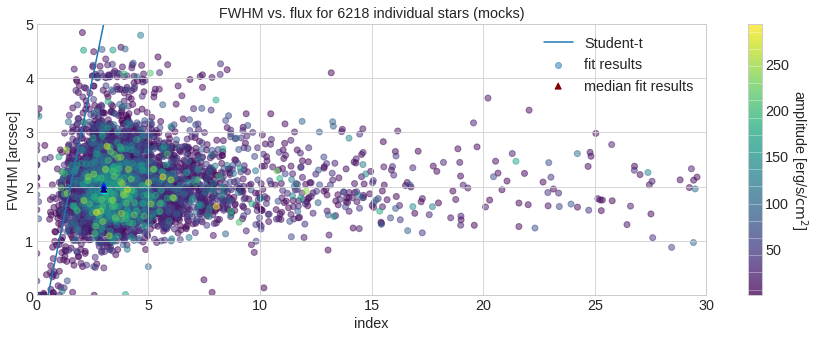

In [70]:
order = np.argsort(amps[withinbouds])

#plt.errorbar(indices[withinbouds], fwhms[withinbouds], xerr=indexerr[withinbouds], yerr=fwhmerr[withinbouds], alpha=0.3, fmt="o", zorder=0)#, c=shots, cmap="prism")
plt.scatter(indices[withinbouds][order], fwhms[withinbouds][order], c=amps[withinbouds][order], alpha=.5, zorder=0, cmap="viridis", label="fit results")
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel(r'amplitude [erg/s/$\mathrm{cm}^2$]', rotation=270)
plt.scatter(idx_1, fwhms_1, marker="^", c=colors[::-1], label="median fit results")
plt.plot((np.arange(0, 20, 0.3)+1)/2., np.arange(0, 20, 0.3), label="Student-t")
#plt.plot((np.arange(0, 20, 0.3)+0.7)/0.8, np.arange(0, 20, 0.3),":", label="Student-t 3")
#plt.plot((np.arange(0, 20, 0.3)+0.4)/0.45, np.arange(0, 20, 0.3), ":", label="Student-t 3")
plt.ylim(0,5)
plt.xlim(0,30)
#plt.yscale("log")
#plt.xscale("log")
plt.xlabel("index")
plt.ylabel("FWHM [arcsec]")
plt.title("FWHM vs. flux for {} individual stars (mocks)".format(len(fwhms[withinbouds])))
plt.legend()
#plt.savefig("plots/FWHM_index_mocks_data.png", bbox_inches="tight")

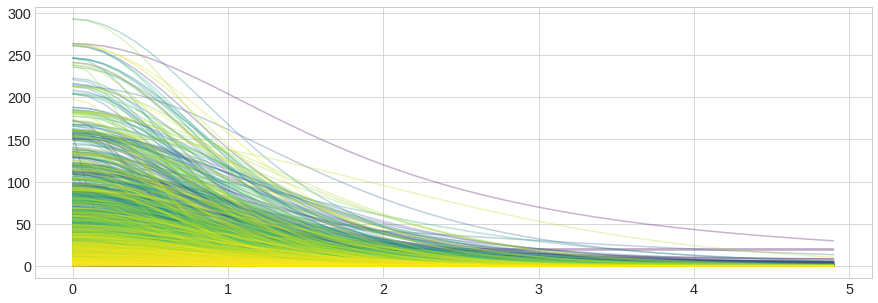

In [30]:
order = np.argsort(indices[withinbouds])

distances = np.arange(0,5,0.1)
amp = 1
FWHM = 1.7
cm_subsection = np.linspace(0,1, len(amps[withinbouds]))
colors = [ cm.viridis(x) for x in cm_subsection ]
for idx, FWHM, amp, color in zip(indices[withinbouds][order], fwhms[withinbouds][order], amps[withinbouds][order], colors):
    plt.plot(distances, moffat_arcsec(distances**2, amp, idx, FWHM), color=color, alpha=0.3)
#plt.colorbar()

In [20]:
import scipy.stats as stats
from astropy.stats import biweight_location, biweight_scale

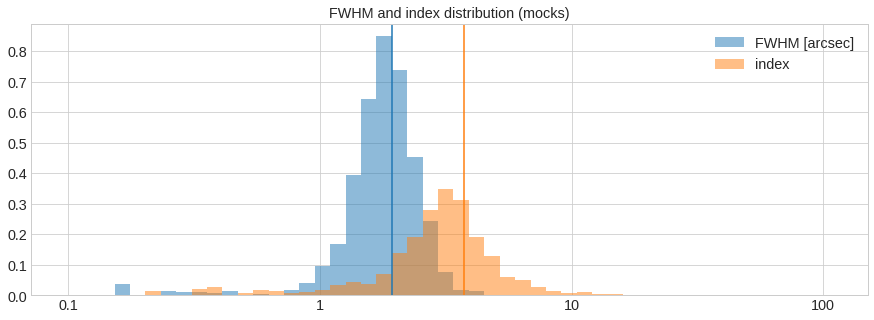

In [71]:
plt.hist(fwhms[withinbouds], bins=np.logspace(-1,2,50), label="FWHM [arcsec]", alpha=0.5, density=True)
#plt.plot(np.arange(0.1, 10, 0.01), stats.lognorm.pdf(np.arange(0.1, 10, 0.01), scale=np.exp(np.nanmedian(np.log(fwhms[withinbouds]))), s=biweight_scale(np.log(fwhms[withinbouds]))), color="tab:blue")
plt.hist(indices[withinbouds], bins=np.logspace(-1,2,50), label="index", alpha=0.5, density=True)#np.logspace(-1,2,50)
#plt.plot(np.arange(0, 100, 0.1), stats.gengamma.pdf(np.arange(0, 100, 0.1), a=4., c=1.3, loc=.8), color="tab:orange")

plt.xscale("log")
plt.axvline(np.nanmedian(fwhms[withinbouds]))
#plt.text(np.nanmedian(fwhms[withinbouds]), 255, "{:.2f}".format(np.nanmedian(fwhms[withinbouds])))
plt.axvline(np.nanmedian(indices[withinbouds]), color="tab:orange")
#plt.text(np.nanmedian(indices[withinbouds]), 255, "{:.2f}".format(np.nanmedian(indices[withinbouds])))
plt.xticks([1e-1, 1, 10, 100], [1e-1, 1, 10, 100])
plt.legend()
plt.xlim(0,150)
plt.title("FWHM and index distribution (mocks)")
#plt.savefig("plots/hist_fwhm_index_mocks_data.png", bbox_inches="tight");

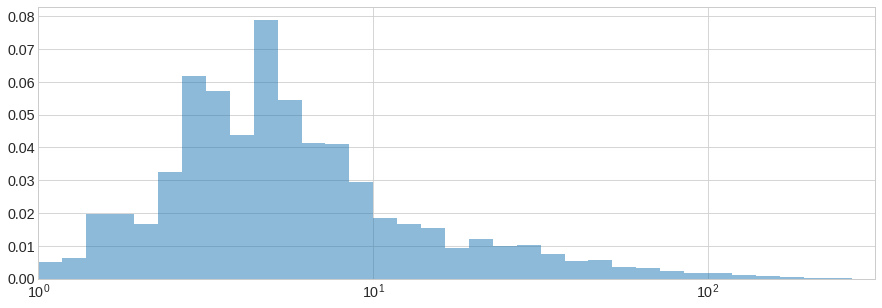

In [123]:
plt.hist(amps[withinbouds], bins=np.logspace(-1,2.5,50), alpha=0.5, density=True)
#loc, scale = np.n
#plt.plot(np.arange(1, 100, 0.5), stats..pdf(np.arange(1, 100, 0.5), scale=loc, s=scale);
plt.xlim(1, 10**2.5)
plt.xscale("log");

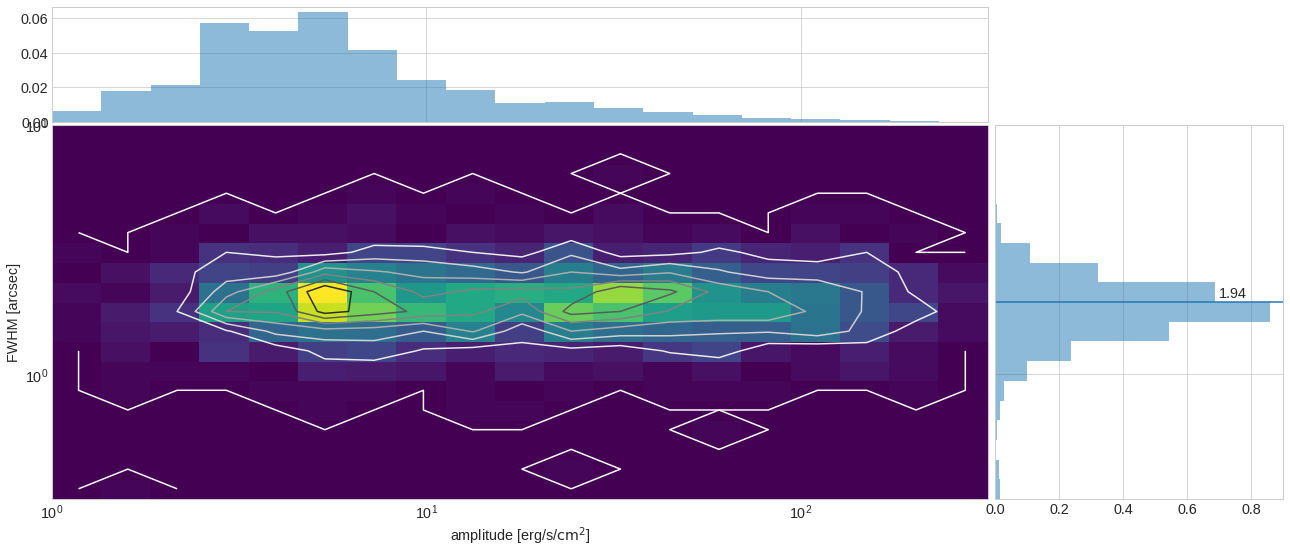

In [166]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(20, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

xbins, ybins = np.logspace(0, 2.5, 20), np.logspace(-0.5, 1, 20)
counts1, xedges, yedges = np.histogram2d(amps[withinbouds], fwhms[withinbouds], bins=(xbins, ybins))
ax.hist2d(amps[withinbouds], fwhms[withinbouds], bins=(xbins, ybins), cmap="viridis")
cs1 = ax.contour(xedges[:-1]+np.diff(xedges)/2., yedges[:-1]+np.diff(yedges)/2., counts1.T)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"amplitude [erg/s/$\mathrm{cm}^2$]")
ax.set_ylabel("FWHM [arcsec]")

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histx.hist(amps[withinbouds], bins=xbins, alpha=0.5, density=True)
ax_histy.hist(fwhms[withinbouds], bins=ybins, orientation='horizontal', alpha=0.5, density=True)
ax_histy.axhline(np.nanmedian(fwhms[withinbouds]))
ax_histy.text(0.7, np.nanmedian(fwhms[withinbouds])+0.1, "{:.2f}".format(np.nanmedian(fwhms[withinbouds])), fontsize="x-large")

#fig.savefig("fwhm_contour_hist.png", bbox_inches="tight");

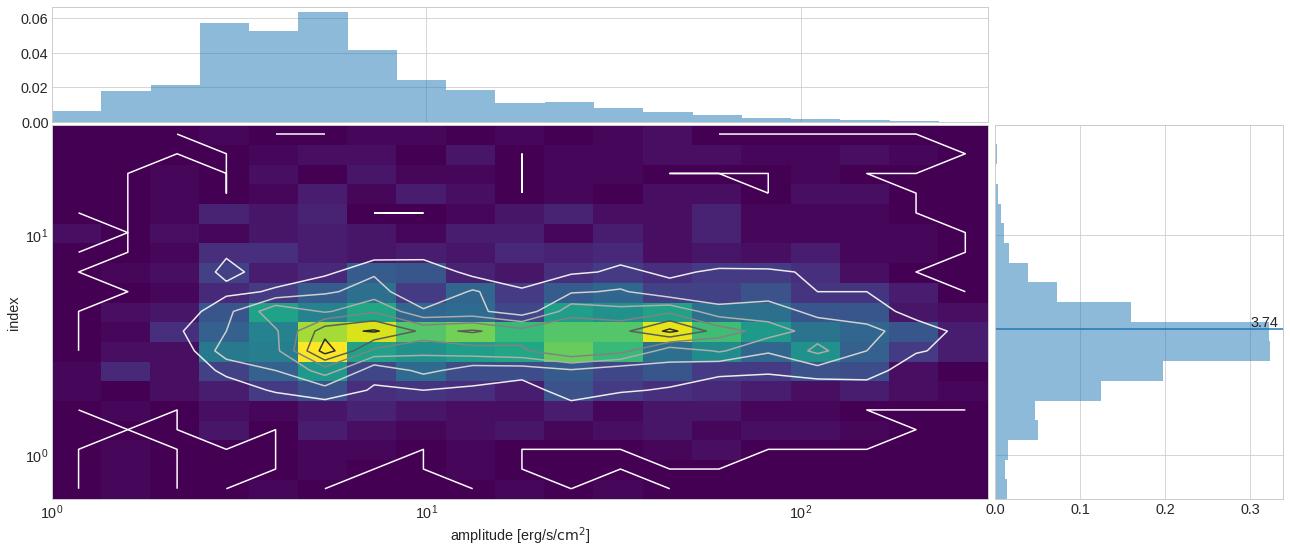

In [168]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(20, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

xbins, ybins = np.logspace(0, 2.5, 20), np.logspace(-0.2, 1.5, 20)
counts1, xedges, yedges = np.histogram2d(amps[withinbouds], indices[withinbouds], bins=(xbins, ybins))
ax.hist2d(amps[withinbouds], indices[withinbouds], bins=(xbins, ybins), cmap="viridis")
cs1 = ax.contour(xedges[:-1]+np.diff(xedges)/2., yedges[:-1]+np.diff(yedges)/2., counts1.T)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"amplitude [erg/s/$\mathrm{cm}^2$]")
ax.set_ylabel("index")

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histx.hist(amps[withinbouds], bins=xbins, alpha=0.5, density=True)
ax_histy.hist(indices[withinbouds], bins=ybins, orientation='horizontal', alpha=0.5, density=True)
ax_histy.axhline(np.nanmedian(indices[withinbouds]))
ax_histy.text(0.3, np.nanmedian(indices[withinbouds])+0.1, "{:.2f}".format(np.nanmedian(indices[withinbouds])), fontsize="x-large")
#fig.savefig("plots/index_contour_hist.png", bbox_inches="tight");

In [21]:
starids = np.array(starids)
startabs = np.array(startabs)
startab_ID = np.array([x.split("_")[3][:-4] for x in startabs])
testdists = np.arange(0,13,0.2)

In [22]:
startab_ID[0], starids[0]

('4877729397819336704', '4877729397819336704')

Number of stars in this bin:  693
[578.8588256835938, 3, 1.7]
[4.31084613 2.23098443 2.01331263]
Number of stars in this bin:  262
[106.61377716064453, 3, 1.7]
[13.10935594  2.48966448  1.80426758]
Number of stars in this bin:  177
[409.8494873046875, 3, 1.7]
[25.11455035  2.59815033  1.76587552]
Number of stars in this bin:  146
[312.3113098144531, 3, 1.7]
[36.43542627  2.59509462  1.65268477]
Number of stars in this bin:  90
[322.0721130371094, 3, 1.7]
[46.59983317  2.54220058  1.64860405]
Number of stars in this bin:  63
[83.7354736328125, 3, 1.7]
[56.9215949   2.45869521  1.5884867 ]
Number of stars in this bin:  59
[70.53521728515625, 3, 1.7]
[64.28465766  2.14944038  1.52303703]
Number of stars in this bin:  41
[95.68003845214844, 3, 1.7]
[79.45077179  2.74296406  1.58841057]
Number of stars in this bin:  38
[135.69161987304688, 3, 1.7]
[90.86658706  3.06723353  1.72333373]
Number of stars in this bin:  28
[103.2590560913086, 3, 1.7]
[105.01189212   1.60815659   1.09113519]
Numbe

/opt/apps/intel18/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/apps/intel18/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/apps/intel18/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/apps/intel18/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures 

[124.6428451538086, 3, 1.7]
[235.12507275   3.14544949   1.50432262]


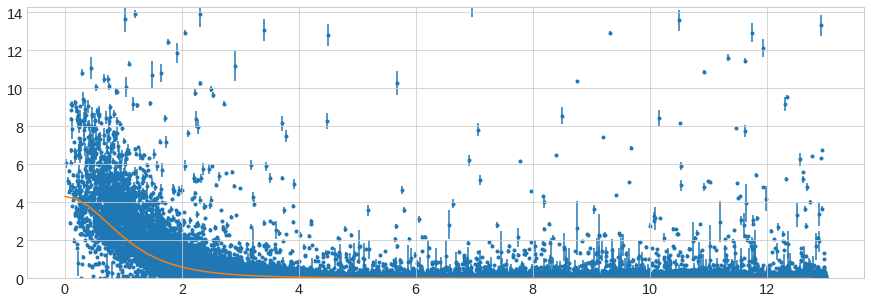

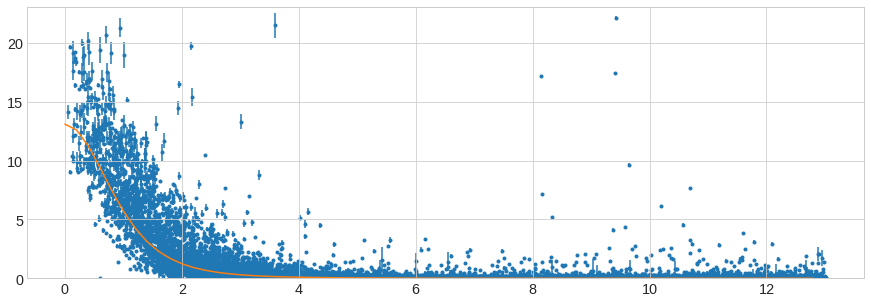

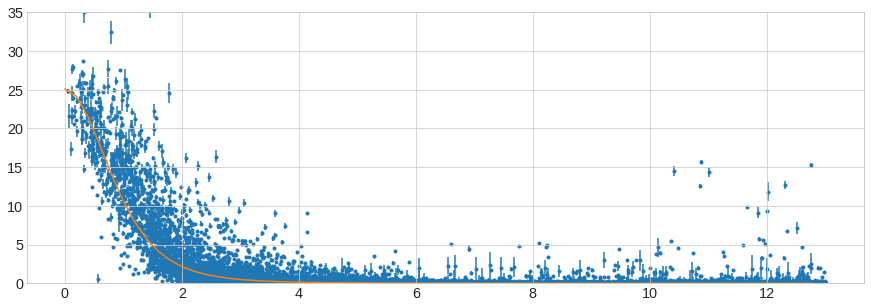

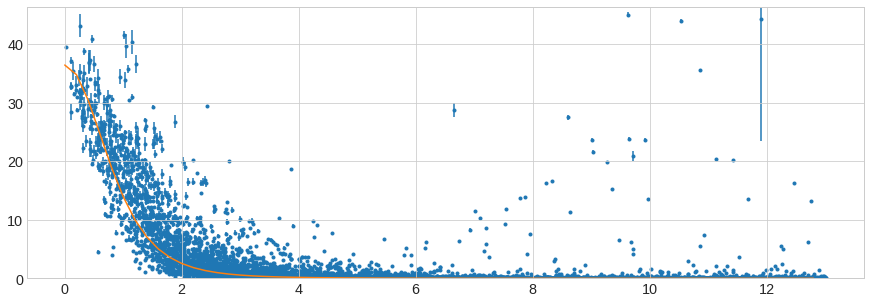

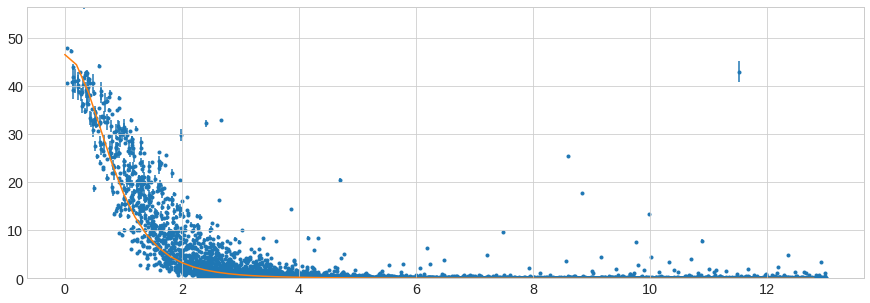

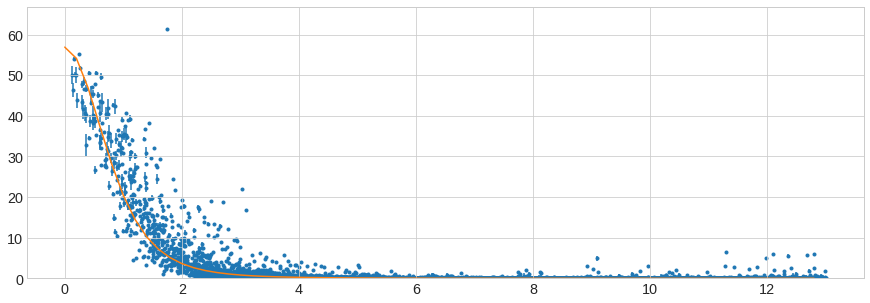

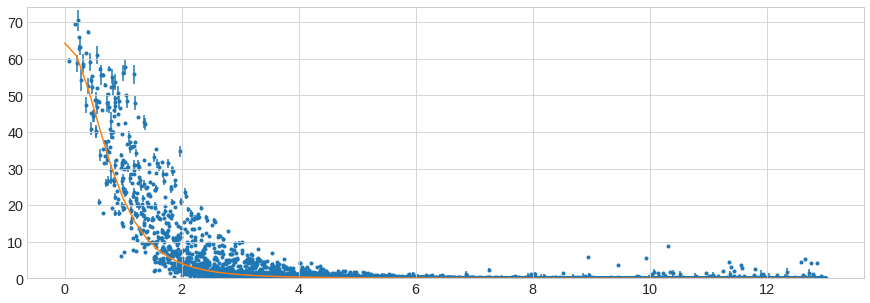

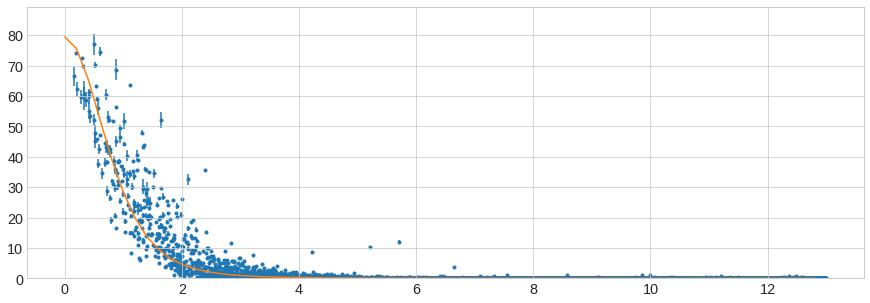

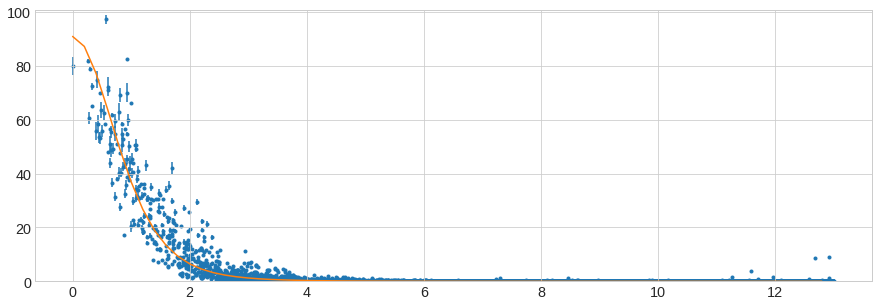

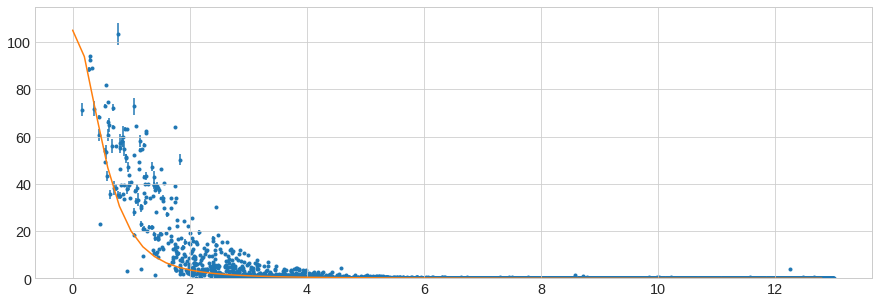

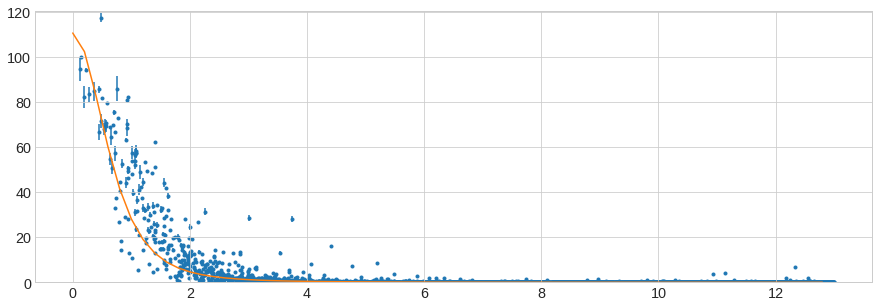

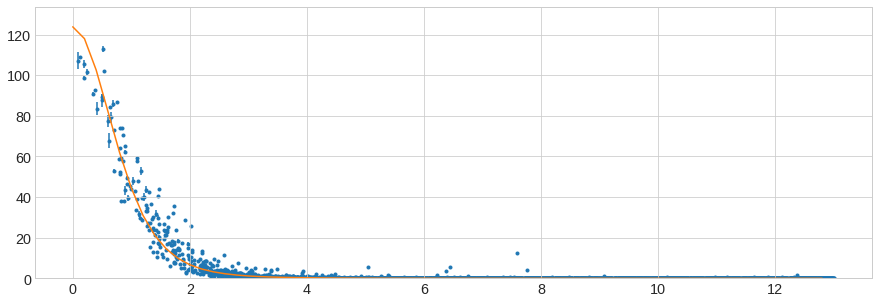

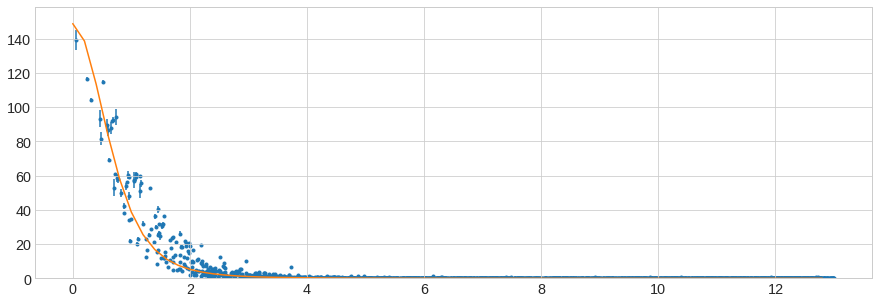

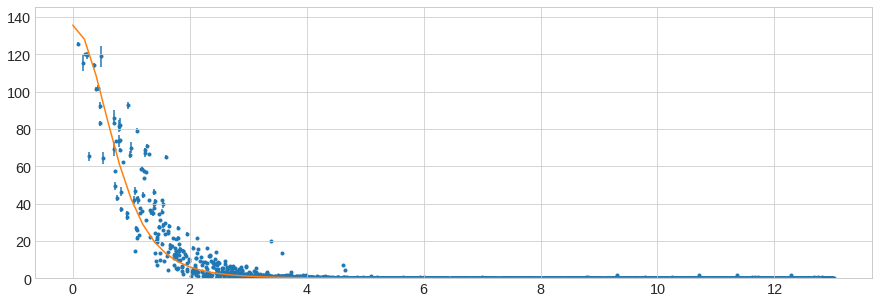

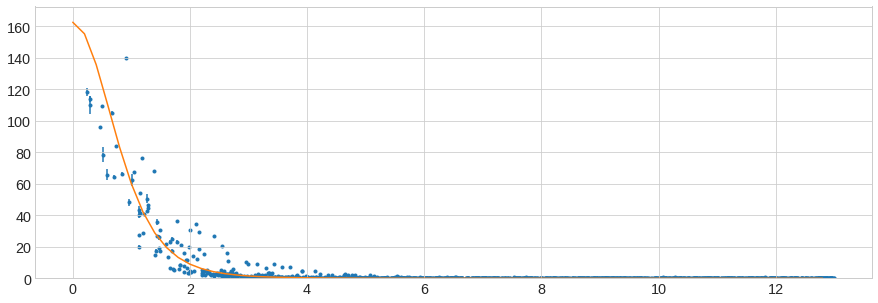

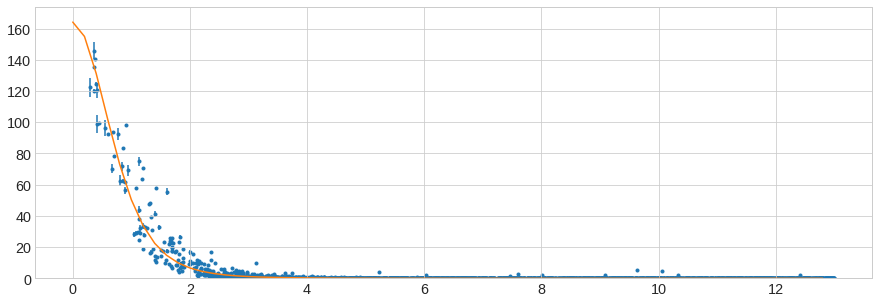

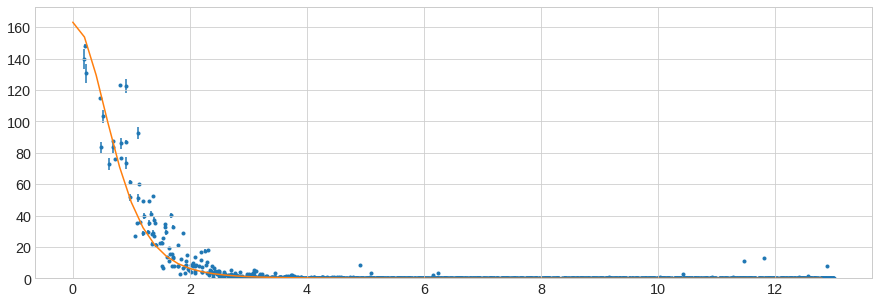

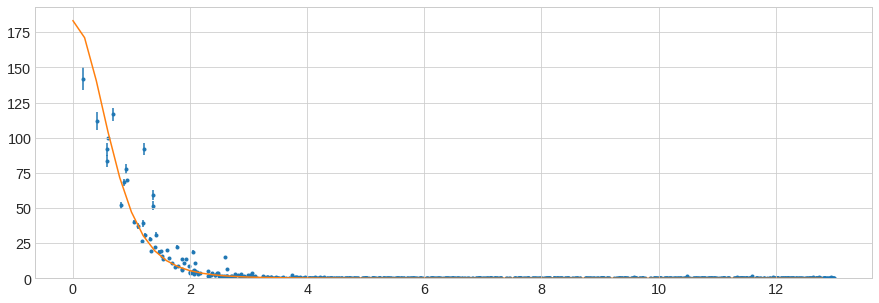

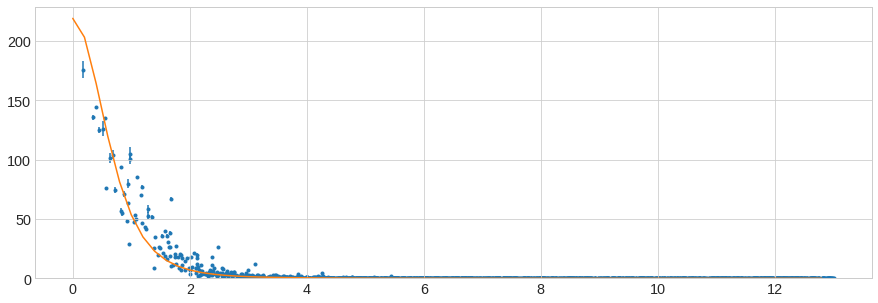

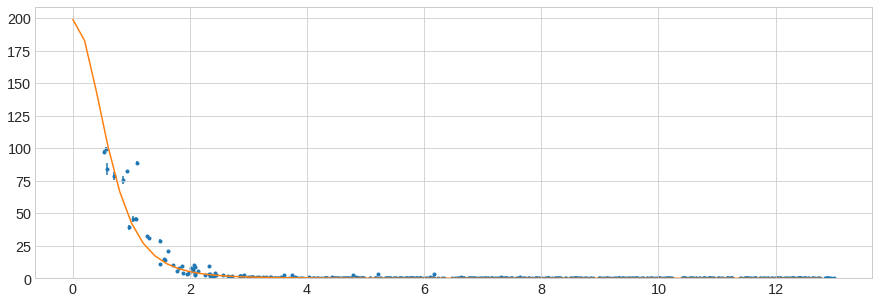

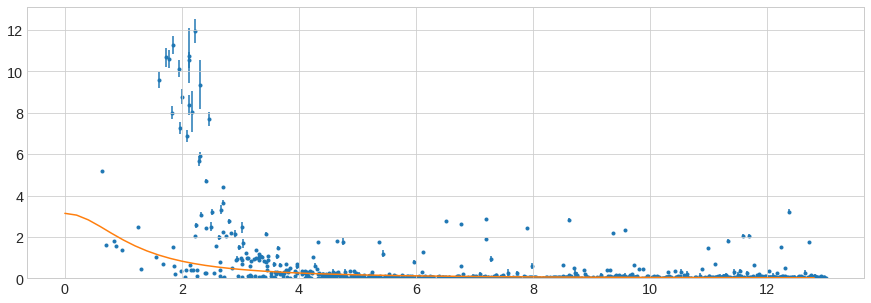

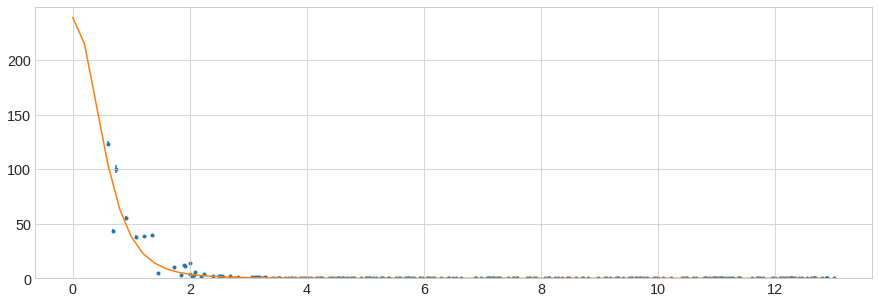

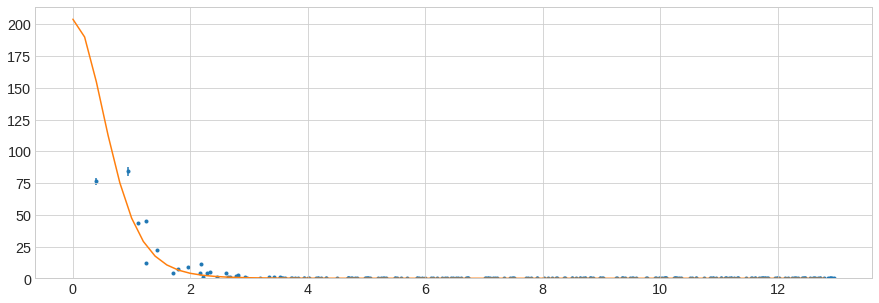

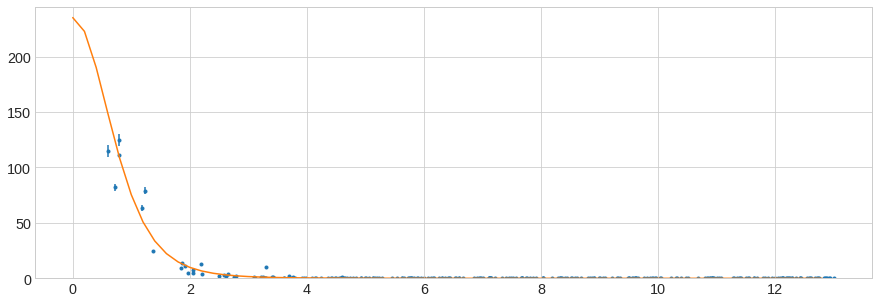

In [23]:
new_fwhms, new_inds, new_amps = [], [], []
new_offs = []
midpoints = []
for lower, upper in zip(np.arange(0,250,10)[:-1], np.arange(0,250,10)[1:]): # np.logspace(0.2,2.2,10)[:-1], np.logspace(0.2,2.2,10)[1:]): #
    ampshere = (amps>=lower)&(amps<upper)&withinbouds
    midpoints.append(lower + (upper-lower)/2.)
    if len(ampshere[ampshere]) == 0:
        continue
    print("Number of stars in this bin: ", len(ampshere[ampshere]))
    
    dist, flux, stds = [], [], []
    #plt.figure()
    for s_id in starids[ampshere]:
        ff_here = startabs[startab_ID==s_id][0]
        a = ascii.read(ff_here)
        fluxhere = (a["flux"]>0.001)
        dist.append(distsq(a[0]["star_ra"], a[0]["star_dec"], a["ra"][fluxhere].data, a["dec"][fluxhere].data))
        flux.append(a["flux"][fluxhere])
        stds.append(a["std"][fluxhere])
        #plt.errorbar(np.sqrt(distsq(a[0]["star_ra"], a[0]["star_dec"], a["ra"][fluxhere].data, a["dec"][fluxhere].data)), a["flux"][fluxhere], yerr=a["std"][fluxhere], fmt=".")
        
    p0 = [np.nanmax(np.concatenate(flux)), 3, 1.7]#, 0.]
    #print(p0)
    try:
        popt, pcov = curve_fit(moffat_arcsec, np.concatenate(dist), np.concatenate(flux), sigma=np.concatenate(stds), p0=p0)
    except:
        pass
    
    if True:
        plt.figure()
        plt.errorbar(np.sqrt(np.concatenate(dist)), np.concatenate(flux), yerr=np.concatenate(stds), fmt=".", zorder=0)
        print(p0)
        print(popt)
        plt.plot(testdists, moffat_arcsec(testdists**2, *popt), zorder=1)
        plt.ylim(0,popt[0]+10)
        new_amps.append(popt[0])
        new_inds.append(popt[1])
        new_fwhms.append(popt[2])


Text(0, 0.5, 'fwhm')

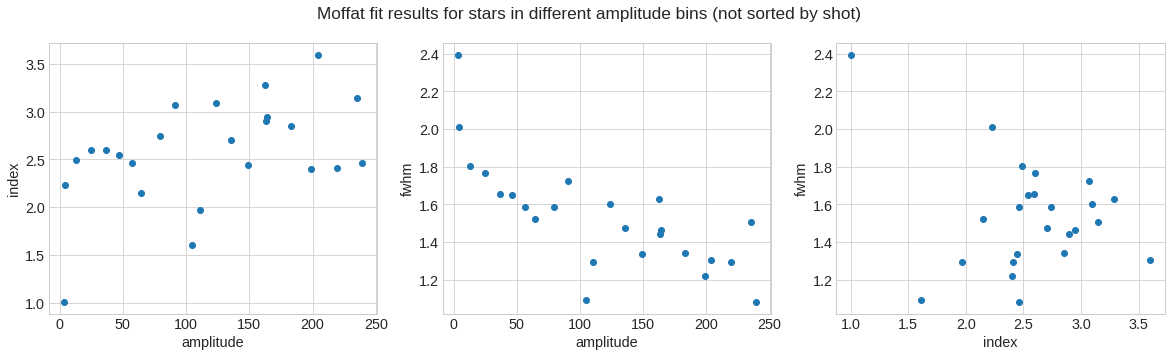

In [24]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(new_amps, new_inds, "o")
plt.xlabel("amplitude")
plt.ylabel("index")
plt.subplot(132)
plt.plot(new_amps, new_fwhms, "o")
plt.xlabel("amplitude")
plt.ylabel("fwhm")
plt.suptitle("Moffat fit results for stars in different amplitude bins (not sorted by shot)", fontsize="xx-large")
plt.subplot(133)
plt.plot(new_inds, new_fwhms, "o")
plt.xlabel("index")
plt.ylabel("fwhm")
#plt.savefig("plots/fitresults_bins_multipleshots.png", bbox_inches="tight")

Text(0.5, 1.0, 'Moffat fit to stars in amplitude bins (not sorted by shot)')

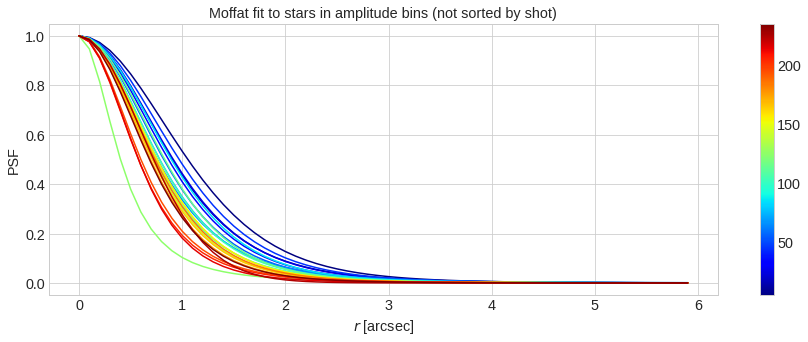

In [260]:
testdists = np.arange(0, 6, 0.1)
cm_subsection = np.linspace(0,1, len(new_amps))
colors = [ cm.jet(x) for x in cm_subsection ]
norm = matplotlib.colors.Normalize(vmin=midpoints[0],vmax=midpoints[-1])
for i in range(len(new_amps)):
    plt.plot(testdists, moffat_arcsec(testdists**2, new_amps[i], new_inds[i], new_fwhms[i])/new_amps[i], color=colors[i])
plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap="jet"))
plt.xlabel(r"$r$ [arcsec]")
plt.ylabel("PSF")
plt.title("Moffat fit to stars in amplitude bins (not sorted by shot)")
#plt.savefig("plots/PSF_amp_multipleshots.png", bbox_inches="tight")

In [157]:
import matplotlib

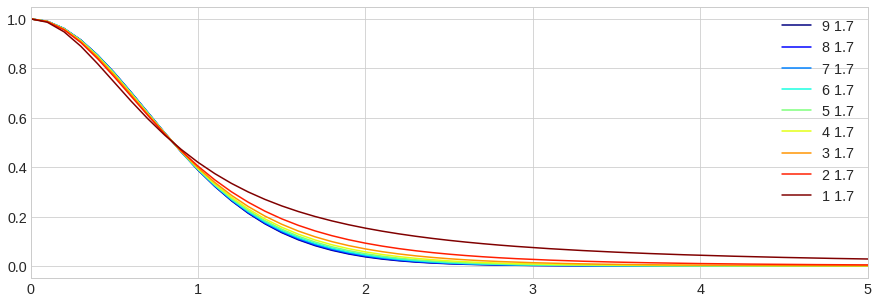

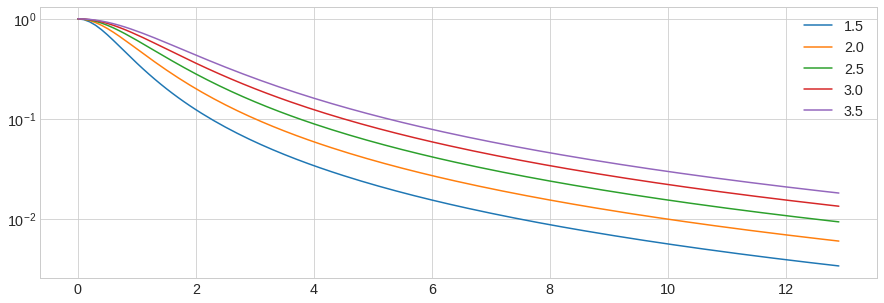

In [55]:
amp, inds = 1., np.arange(1, 10, 1)[::-1]
FWHM = 1.7#(inds+0.7)/0.8
cm_subsection1 = np.linspace(0,1,len(inds))
colors1 = [ cm.jet(x) for x in cm_subsection1 ]
for i, idx in enumerate(inds):
    fwhm0 = 1.7#FWHM[i]
    plt.plot(testdists, moffat_arcsec(testdists**2, amp, idx, fwhm0), label="{} {}".format(idx, fwhm0), color=colors1[i]) # *(idx-1)/(np.pi*(FWHM/(2 * np.sqrt(2**(1/3.)-1)))**2)
plt.legend()
plt.xlim(0,5)


amp, FWHM, inds = 1., np.arange(1.5, 4, 0.5), 2.
plt.figure()
for fwhm_0 in FWHM:
    plt.plot(testdists, moffat_arcsec(testdists**2, amp, idx, fwhm_0), label=fwhm_0) # *(idx-1)/(np.pi*(FWHM/(2 * np.sqrt(2**(1/3.)-1)))**2)
plt.legend()
plt.yscale("log")

Number of stars in this bin:  41
Number of stars in this bin:  194
Number of stars in this bin:  273
Number of stars in this bin:  222
Number of stars in this bin:  198
Number of stars in this bin:  242
Number of stars in this bin:  213
Number of stars in this bin:  168
Number of stars in this bin:  125


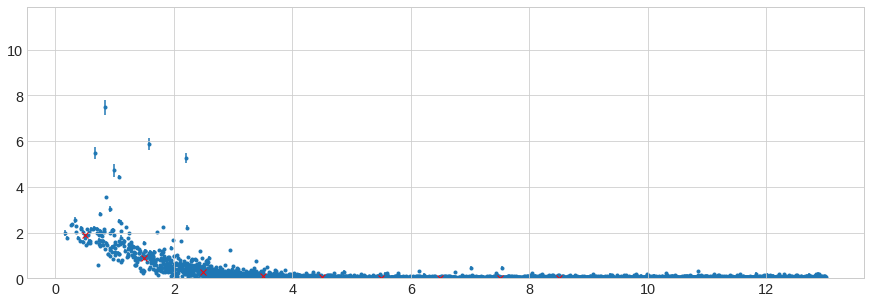

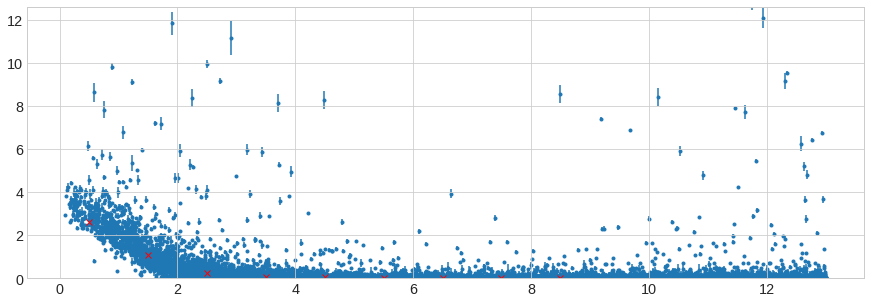

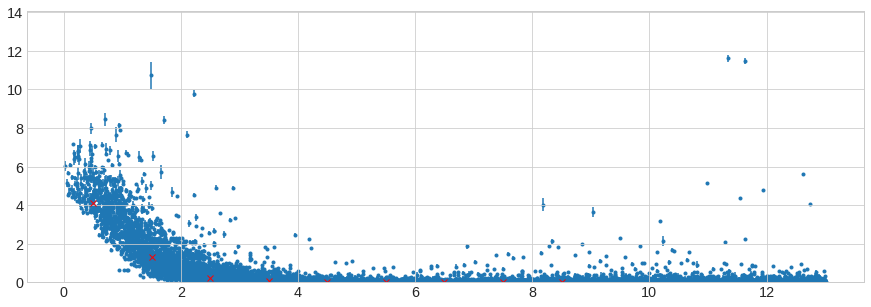

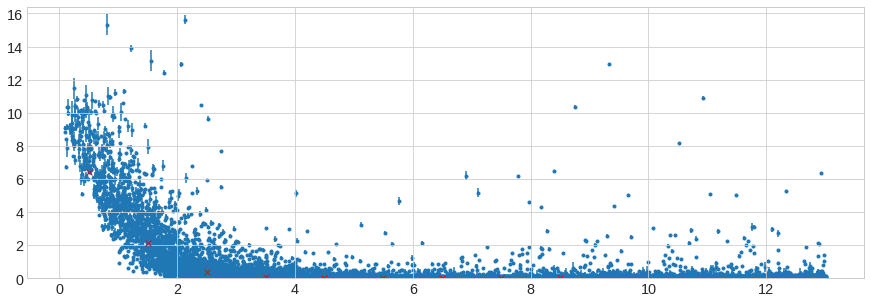

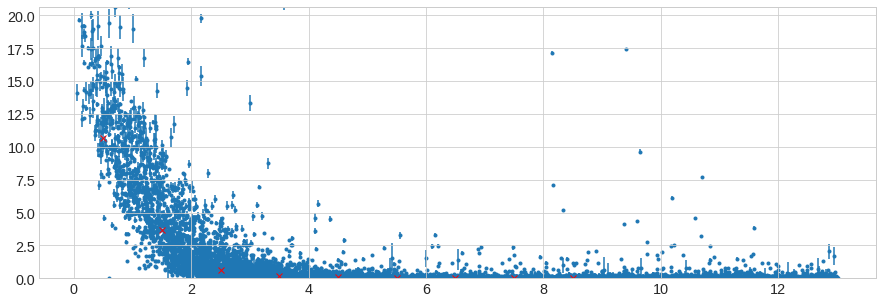

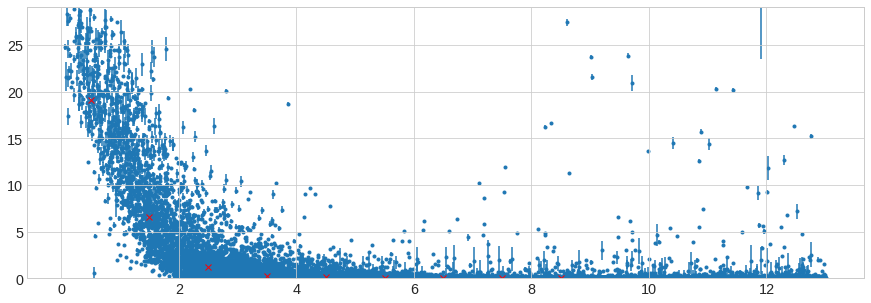

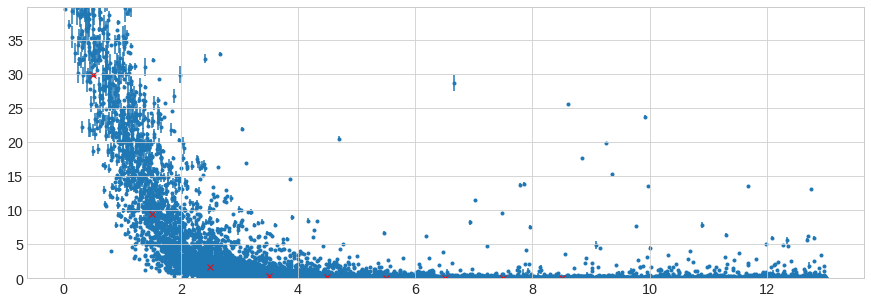

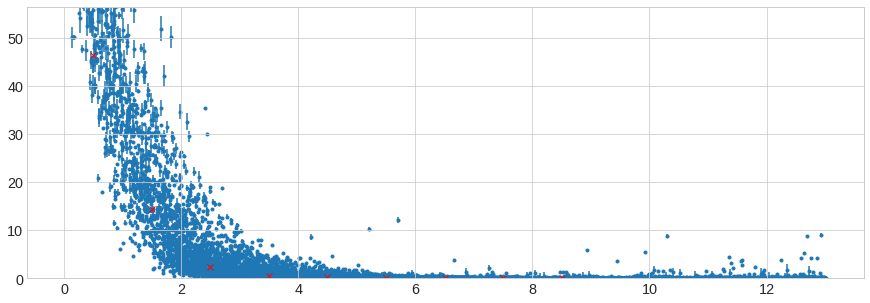

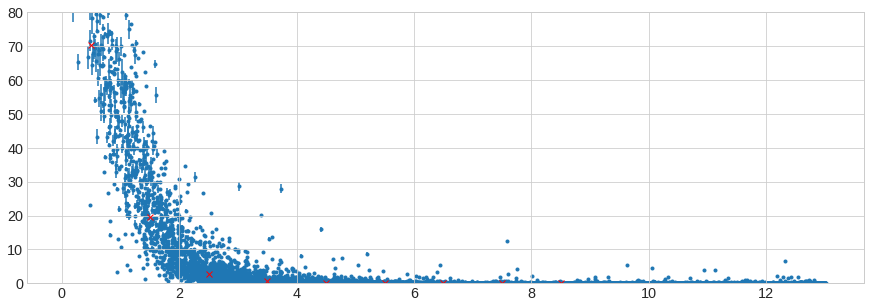

In [25]:
radbins = np.arange(0,10,1)
midpoints = []
radpsfs = []
for lower, upper in zip( np.logspace(0.2,2.2,10)[:-1], np.logspace(0.2,2.2,10)[1:]): #np.arange(0,250,10)[:-1], np.arange(0,250,10)[1:]): #
    ampshere = (amps>=lower)&(amps<upper)&withinbouds
    midpoints.append(lower + (upper-lower)/2.)
    if len(ampshere[ampshere]) == 0:
        continue
    print("Number of stars in this bin: ", len(ampshere[ampshere]))
    
    dist, flux, stds = [], [], []
    mids = []
    #plt.figure()
    for s_id in starids[ampshere]:
        ff_here = startabs[startab_ID==s_id][0]
        a = ascii.read(ff_here)
        fluxhere = (a["flux"]>0.001)
        
        dist.append(np.sqrt(distsq(a[0]["star_ra"], a[0]["star_dec"], a["ra"][fluxhere].data, a["dec"][fluxhere].data))) # ACHTUNG: richtiger Abstand, nicht Quadrat
        
        flux.append(a["flux"][fluxhere])
        stds.append(a["std"][fluxhere])
        #plt.errorbar(np.sqrt(distsq(a[0]["star_ra"], a[0]["star_dec"], a["ra"][fluxhere].data, a["dec"][fluxhere].data)), a["flux"][fluxhere], yerr=a["std"][fluxhere], fmt=".")
        
    dist, flux, stds = np.concatenate(dist), np.concatenate(flux), np.concatenate(stds)
    midrad = []
    for radlow, radup in zip(radbins[:-1], radbins[1:]):
        midrad.append((radlow+radup)/2)
        radhere = (dist>radlow)&(dist<=radup)
        mids.append(np.nanmedian(flux[radhere]))
    radpsfs.append(mids)
    
    if True:
        plt.figure()
        plt.errorbar(dist, flux, yerr=stds, fmt=".", zorder=0)
        plt.plot(midrad, mids, "xr", zorder=1)
        plt.ylim(0, mids[0]+10)
        new_amps.append(popt[0])
        new_inds.append(popt[1])
        new_fwhms.append(popt[2])


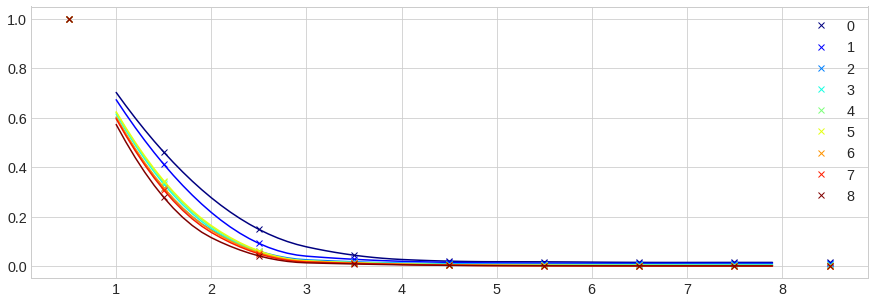

In [33]:
cm_subsection = np.linspace(0,1, len(radpsfs))
colors = [ cm.jet(x) for x in cm_subsection ]
for i, mid in enumerate(radpsfs):
    plt.plot(radbins[:-1]+radbins[1]/2., mid/mid[0], "x", label=i, color=colors[i])
    plt.plot(np.arange(1,8,0.1), interp1d(radbins[:-1]+radbins[1]/2., mid/mid[0], kind="quadratic")(np.arange(1,8,0.1)), color=colors[i])
#plt.yscale("log")
plt.legend()

In [27]:
from scipy.interpolate import interp1d

In [241]:
from scipy.ndimage import gaussian_filter

In [29]:
plt.errorbar(amps[withinbouds], offsets[withinbouds]/amps[withinbouds], xerr=amperr[withinbouds], yerr=0.*offseterr[withinbouds], alpha=0.2, fmt="o", zorder=0)#, c=shots, cmap="prism")
for lower, upper in zip(np.logspace(0.5,2.2,8)[:-1], np.logspace(0.5,2.2,8)[1:]): #np.arange(0,300,20), np.arange(10,320,20)):
    ampshere = (amps>=lower)&(amps<upper)&withinbouds
    plt.plot(lower+(upper-lower)/2, np.nanmedian(offsets[ampshere]/amps[ampshere]),marker="v", c="tab:red", alpha=1.0, zorder=1)
    #plt.axvline(lower, linestyle="--", color="red")
    #plt.axvline(upper, linestyle="--", color="red")
plt.xlim(1,300)
plt.ylim(-0.002,0.002)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"amplitude [erg/s/$\mathrm{cm}^2$]")
plt.ylabel("offset / amplitude")
plt.title("offset / amplitude vs. amplitude for {} individual stars (moffat)".format(len(fwhms[withinbouds])))
#plt.savefig("plots/offset_flux_individual_moffat_doublog.png", bbox_inches="tight")

NameError: name 'offsets' is not defined